## WaveGrad2 inference code
Edit the variables **checkpoint_path** and **text**.<br>
And then run the entire code to generate audio output, it will take some time.

In [1]:
import os
import librosa as rosa
import torch
import matplotlib
import matplotlib.pyplot as plt
import random
import numpy as np
import IPython.display as ipd

matplotlib.use('Agg')

%matplotlib inline

from matplotlib.colors import Normalize
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from argparse import ArgumentParser
from omegaconf import OmegaConf
from unicodedata import normalize
import re

from lightning_model import Wavegrad2
from text import Language
from text.symbols import eng_symbols
from g2p_en import G2p
from pypinyin import pinyin, Style
from dataloader import TextAudioDataset
from utils.stft import STFTMag

### Load models from checkpoint
write down your paths below.

In [2]:
# checkpoint_path = '/workspace/checkpoint/wavegrad2_07_08_07_epoch=403.ckpt'
checkpoint_path = '/workspace/checkpoint/last.ckpt'
speaker = 'LJSpeech'

net=Wavegrad2.load_from_checkpoint(checkpoint_path).cuda().eval()
net.freeze()

hparams =net.hparams

### Prepare text input

In [3]:
# text="On Friday night in Bridgeport expect a temperature of minus four degrees Fahrenheit."
text="in some yards"
# text="no doubt, on the removal of ikey solomons from the scene, his mantle fell upon worthy successors."
    
g2p = G2p()
phones = []
words = re.split(r"([,;.\-\?\!\s+])", text)
for w in words:
    phones += list(filter(lambda p: p != " ", g2p(w)))
phones = "{" + "}{".join(phones) + "}"
phones = re.sub(r"\{[^\w\s]?\}", "{sp}", phones)
print('g2p: ',phones)
    
trainset = TextAudioDataset(hparams, hparams.data.train_dir, hparams.data.train_meta, train=False)

text=trainset.get_text(phones)
text=text.unsqueeze(0)
    
speaker_dict = {spk: idx for idx, spk in enumerate(hparams.data.speakers)}
spk_id=[speaker_dict[speaker]]
spk_id = torch.LongTensor(spk_id)
    
text=text.cuda()
spk_id=spk_id.cuda()
    
wav_recon, align, *_ = net.inference(text,spk_id, pace=1.0)

g2p:  {IH0}{N}{S}{AH1}{M}{Y}{AA1}{R}{D}{Z}


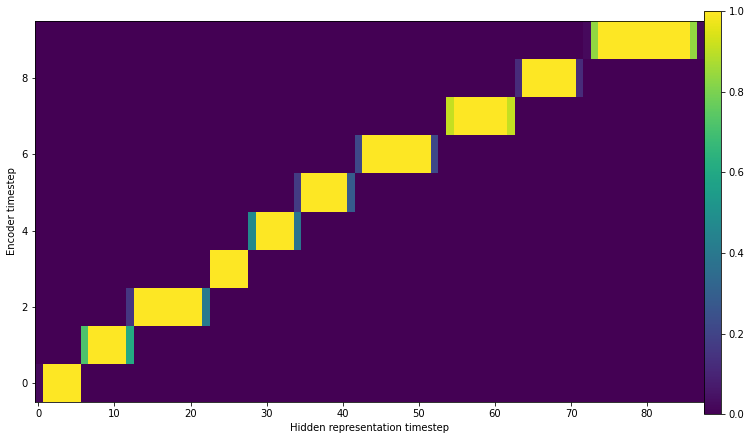

In [4]:
%matplotlib inline
align = align.cpu()
align = align.squeeze(0)
fig = plt.figure(figsize=(12, 7))
plt.imshow(align, aspect='auto', origin='lower', interpolation='none',
           norm=Normalize(vmin=0.0, vmax=1.0))
   
plt.xlabel('Hidden representation timestep')
plt.ylabel('Encoder timestep')
    
cax = plt.axes([0.9, 0.1, 0.02, 0.8])
plt.colorbar(cax=cax)

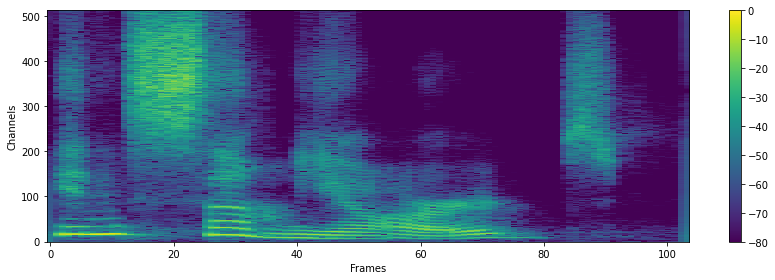

In [5]:
%matplotlib inline
wav_recon = wav_recon.cpu().squeeze(0)
stft = STFTMag()
fig = plt.figure(figsize=(12, 4))
plt.imshow(rosa.amplitude_to_db(stft(wav_recon).numpy(),ref=np.max, top_db = 80.), 
           aspect='auto', 
           origin='lower', 
           interpolation='none')
plt.colorbar()
plt.xlabel('Frames')
plt.ylabel('Channels')
plt.tight_layout()

In [6]:
ipd.Audio(wav_recon, rate=hparams.audio.sampling_rate)